# Skills demonstrated 
- Data gathering
- Data wrangling and cleaning
- Features engineering
- Feature selection
    - Variance analysis
    - Recursive variable elimination
- Model building
    - Linear regression
    - Support vector machines
    - K nearest neighbors
    - Neural Networks
    - Gradient Booster
    - XGBoosters
- Analysis interpretation
    

## The goal of this analysis will be to determine the causal relationship between diet and being overweight or obese.
#### The target audience of this notebook is other data scientists. There is a summary notebook written to the general public.

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import pdb
import xport
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

In [2]:
pd.set_option('display.max_rows', 200)

### All data was gathered off of this page from the CDC: https://wwwn.cdc.gov/nchs/nhanes/search/nnyfs12.aspx

In [3]:
file_map = {
    'Y_DR1TOT.XPT': 'dietary_interview_total',
    'Y_HUQ.XPT': 'health_utilization',
    'Y_BMX.XPT': 'body_measures',
    'Y_DEMO.XPT': 'demographics',
    'Y_CVX.XPT': 'cardiovascular_fitness'
}

In [4]:
os.chdir('data_files')

#### Convert all the data from xpt format dataframes

In [5]:
dfs = {}
for file_name in file_map.keys():
    with open(file_name, 'rb') as in_file:
        dfs[file_map[file_name]] = xport.to_dataframe(in_file)

### Familiarize Myself with the Data

In [6]:
for file_name, df in dfs.items():
    print(file_name, len(df.columns))

dietary_interview_total 99
health_utilization 4
body_measures 22
demographics 27
cardiovascular_fitness 33


In [7]:
for file_name, df in dfs.items():
    print(file_name, '\n', df.columns, '\n')

dietary_interview_total 
 Index(['SEQN', 'WTDRD1', 'DR1DRSTZ', 'DR1EXMER', 'DR1DBIH', 'DR1DAY',
       'DR1LANG', 'DR1MNRSP', 'DR1HELPD', 'DBQ095Z', 'DBD100', 'DRQSPREP',
       'DR1STY', 'DR1SKY', 'DRQSDIET', 'DRQSDT1', 'DRQSDT2', 'DRQSDT3',
       'DRQSDT4', 'DRQSDT5', 'DRQSDT6', 'DRQSDT7', 'DRQSDT8', 'DRQSDT9',
       'DRQSDT10', 'DRQSDT11', 'DRQSDT12', 'DRQSDT91', 'DR1TNUMF', 'DR1TKCAL',
       'DR1TPROT', 'DR1TCARB', 'DR1TSUGR', 'DR1TFIBE', 'DR1TTFAT', 'DR1TSFAT',
       'DR1TMFAT', 'DR1TPFAT', 'DR1TCHOL', 'DR1TATOC', 'DR1TATOA', 'DR1TRET',
       'DR1TVARA', 'DR1TACAR', 'DR1TBCAR', 'DR1TCRYP', 'DR1TLYCO', 'DR1TLZ',
       'DR1TVB1', 'DR1TVB2', 'DR1TNIAC', 'DR1TVB6', 'DR1TFOLA', 'DR1TFA',
       'DR1TFF', 'DR1TFDFE', 'DR1TCHL', 'DR1TVB12', 'DR1TB12A', 'DR1TVC',
       'DR1TVD', 'DR1TVK', 'DR1TCALC', 'DR1TPHOS', 'DR1TMAGN', 'DR1TIRON',
       'DR1TZINC', 'DR1TCOPP', 'DR1TSODI', 'DR1TPOTA', 'DR1TSELE', 'DR1TCAFF',
       'DR1TTHEO', 'DR1TALCO', 'DR1TMOIS', 'DR1TS040', 'DR1TS060', 'D

### Inspect the dietary variable information

In [8]:
diet_df = dfs['dietary_interview_total']

In [9]:
diet_df.shape

(1576, 99)

In [10]:
diet_df.head()

,SEQN,WTDRD1,DR1DRSTZ,DR1EXMER,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,DR1TP184,DR1TP204,DR1TP205,DR1TP225,DR1TP226,DR1_300,DR1_320Z,DR1_330Z,DR1BWATZ,DR1TWS
0,71917.0,37028.609239,1.0,3.0,19.0,5.0,1.0,1.0,13.0,1.0,...,0.017,0.235,0.032,0.031,0.051,2.0,607.31,607.31,0.00,1.0
1,71918.0,11431.383494,1.0,3.0,11.0,6.0,1.0,2.0,1.0,1.0,...,0.001,0.118,0.041,0.003,0.045,2.0,177.75,59.25,118.50,1.0
2,71919.0,51445.229102,1.0,4.0,30.0,2.0,1.0,1.0,13.0,1.0,...,0.000,0.361,0.020,0.039,0.029,2.0,503.33,503.33,0.00,1.0
3,71920.0,53039.717476,1.0,4.0,27.0,6.0,1.0,1.0,13.0,1.0,...,0.000,0.000,0.000,0.000,0.000,2.0,859.13,0.00,859.13,2.0
4,71921.0,97289.709795,1.0,3.0,24.0,2.0,1.0,2.0,13.0,4.0,...,0.006,0.056,0.022,0.008,0.015,2.0,148.13,148.13,0.00,1.0


In [11]:
diet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1576 entries, 0 to 1575
Data columns (total 99 columns):
SEQN        1576 non-null float64
WTDRD1      1518 non-null float64
DR1DRSTZ    1576 non-null float64
DR1EXMER    1530 non-null float64
DR1DBIH     1530 non-null float64
DR1DAY      1530 non-null float64
DR1LANG     1515 non-null float64
DR1MNRSP    1506 non-null float64
DR1HELPD    1515 non-null float64
DBQ095Z     1530 non-null float64
DBD100      861 non-null float64
DRQSPREP    1530 non-null float64
DR1STY      1530 non-null float64
DR1SKY      140 non-null float64
DRQSDIET    1530 non-null float64
DRQSDT1     51 non-null float64
DRQSDT2     3 non-null float64
DRQSDT3     0 non-null float64
DRQSDT4     2 non-null float64
DRQSDT5     0 non-null float64
DRQSDT6     1 non-null float64
DRQSDT7     0 non-null float64
DRQSDT8     4 non-null float64
DRQSDT9     0 non-null float64
DRQSDT10    2 non-null float64
DRQSDT11    3 non-null float64
DRQSDT12    0 non-null float64
DRQSDT91    

In [12]:
diet_df.describe()

,SEQN,WTDRD1,DR1DRSTZ,DR1EXMER,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,DR1TP184,DR1TP204,DR1TP205,DR1TP225,DR1TP226,DR1_300,DR1_320Z,DR1_330Z,DR1BWATZ,DR1TWS
count,1576.000000,1518.000000,1576.000000,1530.000000,1530.000000,1530.000000,1515.000000,1506.000000,1515.000000,1530.000000,...,1518.000000,1518.000000,1518.000000,1518.000000,1518.000000,1530.000000,1518.000000,1518.000000,1518.000000,1530.000000
mean,72704.500000,35355.405138,1.124365,4.932680,20.227451,4.430065,1.160396,1.630146,7.351815,3.492810,...,0.007580,0.105696,0.013764,0.014173,0.027877,2.081699,542.642016,288.568439,254.073577,7.439869
std,455.096327,23961.371654,0.677823,11.775146,13.485521,2.213434,0.491690,1.307019,5.639634,10.524394,...,0.020609,0.102826,0.041431,0.015628,0.073227,0.688496,649.854176,540.200018,508.195210,22.902457
min,71917.000000,6764.142902,1.000000,1.000000,-3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,72310.750000,19380.147427,1.000000,2.000000,9.000000,2.000000,1.000000,1.000000,2.000000,1.000000,...,0.000000,0.036250,0.002000,0.005000,0.002000,2.000000,103.690000,0.000000,0.000000,1.000000
50%,72704.500000,28008.590572,1.000000,3.000000,20.000000,5.000000,1.000000,1.000000,8.000000,1.000000,...,0.001000,0.073500,0.005000,0.010000,0.006000,2.000000,375.000000,0.000000,0.000000,1.000000
75%,73098.250000,45262.041947,1.000000,4.000000,30.000000,6.000000,1.000000,2.000000,13.000000,4.000000,...,0.004000,0.139000,0.011000,0.019000,0.024000,2.000000,740.637500,385.120000,355.500000,2.000000
max,73492.000000,181231.077957,5.000000,91.000000,74.000000,7.000000,4.000000,12.000000,14.000000,99.000000,...,0.423000,0.701000,0.634000,0.227000,0.984000,9.000000,8591.250000,8591.250000,6038.400000,99.000000


### These are the variables that will be used in the analysis
- DR1TNUMF - Number of foods reported
- DR1TKCAL - Energy (kcal)
- DR1TPROT - Protein (gm)
- DR1TCARB - Carbohydrate (gm)
- DR1TSUGR - Total sugars (gm)
- DR1TFIBE - Dietary fiber (gm)
- DR1TTFAT - Total fat (gm)
- DR1TSFAT - Total saturated fatty acids (gm)
- DR1TMFAT - Total monounsaturated fatty acids (gm)
- DR1TPFAT - Total polyunsaturated fatty acids (gm)
- DR1TCHOL - Cholesterol (mg)
- DR1TATOC - Vitamin E as alpha-tocopherol (mg)
- DR1TATOA - Added alpha-tocopherol (Vitamin E) (mg)
- DR1TRET - Retinol (mcg)
- DR1TVARA - Vitamin A, RAE (mcg)
- DR1TACAR - Alpha-carotene (mcg)
- DR1TBCAR - Beta-carotene (mcg)
- DR1TCRYP - Beta-cryptoxanthin (mcg)
- DR1TLYCO - Lycopene (mcg)
- DR1TLZ - Lutein + zeaxanthin (mcg)
- DR1TVB1 - Thiamin (Vitamin B1) (mg)
- DR1TVB2 - Riboflavin (Vitamin B2) (mg)
- DR1TNIAC - Niacin (mg)
- DR1TVB6 - Vitamin B6 (mg)
- DR1TFOLA - Total folate (mcg)
- DR1TFA - Folic acid (mcg)
- DR1TFF - Food folate (mcg)
- DR1TFDFE - Folate, DFE (mcg)
- DR1TCHL - Total choline (mg)
- DR1TVB12 - Vitamin B12 (mcg)
- DR1TB12A - Added vitamin B12 (mcg)
- DR1TVC - Vitamin C (mg)
- DR1TVD - Vitamin D (D2 + D3) (mcg)
- DR1TVK - Vitamin K (mcg)
- DR1TCALC - Calcium (mg)
- DR1TPHOS - Phosphorus (mg)
- DR1TMAGN - Magnesium (mg)
- DR1TIRON - Iron (mg)
- DR1TZINC - Zinc (mg)
- DR1TCOPP - Copper (mg)
- DR1TSODI - Sodium (mg)
- DR1TPOTA - Potassium (mg)
- DR1TSELE - Selenium (mcg)
- DR1TCAFF - Caffeine (mg)
- DR1TTHEO - Theobromine (mg)
- DR1TALCO - Alcohol (gm)
- DR1TMOIS - Moisture (gm)

- DR1_320Z - Total plain water drank yesterday (gm)
- DR1_330Z - Total tap water drank yesterday (gm)
- DR1BWATZ - Total bottled water drank yesterday (gm)
- DR1TWS - Tap water source

In [13]:
variables_to_be_used = [
    'SEQN',
    'DR1TNUMF',
    'DR1TKCAL',
    'DR1TPROT',
    'DR1TCARB',
    'DR1TSUGR',
    'DR1TFIBE',
    'DR1TTFAT',
    'DR1TSFAT',
    'DR1TMFAT',
    'DR1TPFAT',
    'DR1TCHOL',
    'DR1TATOC',
    'DR1TATOA',
    'DR1TRET',
    'DR1TVARA',
    'DR1TACAR',
    'DR1TBCAR',
    'DR1TCRYP',
    'DR1TLYCO',
    'DR1TLZ',
    'DR1TVB1',
    'DR1TVB2',
    'DR1TNIAC',
    'DR1TVB6',
    'DR1TFOLA',
    'DR1TFA',
    'DR1TFF',
    'DR1TFDFE',
    'DR1TCHL',
    'DR1TVB12',
    'DR1TB12A',
    'DR1TVC',
    'DR1TVD',
    'DR1TVK',
    'DR1TCALC',
    'DR1TPHOS',
    'DR1TMAGN',
    'DR1TIRON',
    'DR1TZINC',
    'DR1TCOPP',
    'DR1TSODI',
    'DR1TPOTA',
    'DR1TSELE',
    'DR1TCAFF',
    'DR1TTHEO',
    'DR1TALCO',
    'DR1TMOIS', 
    'DR1_320Z',
    'DR1_330Z',
    'DR1BWATZ',
    'DR1TWS'
]

#### Drop all datapoints where the recall status shows the data is not reliable. Only a recall status of 1 is considered reliable.

In [14]:
# Number of datapoints to be dropped
diet_df[(diet_df.DR1DRSTZ != 1)].shape

(58, 99)

In [15]:
diet_df = diet_df[(diet_df.DR1DRSTZ == 1)]

In [16]:
diet_df = diet_df.drop(['DR1DRSTZ'], axis=1)

#### Drop respondents who were on any kind of diet. There are a minimal number of participants on diets and it would be safe to assume that those who were were not eating what they would on a typical day

In [17]:
# Number of datapoints to be dropped
diet_df[diet_df.DRQSDIET == 1].shape

(68, 98)

In [18]:
diet_df = diet_df[diet_df.DRQSDIET != 1]

#### Drop all the other features that had to do with what kind of diet the person was on

In [19]:
columns_to_drop = [var for var in diet_df.columns.tolist() if var.startswith('DRQSD')]
diet_df = diet_df.drop(columns_to_drop, axis=1)

#### Drop data where the respondent reported it was not their usual intake. The goal here is to discover causal relationships between a persons typical diet and some key health metrics. If the participant is reporting that the data is not typical, then it should not be used. A code of 2 means the participant said their intake was typical.

In [20]:
# Number of datapoints to be dropped
diet_df[diet_df.DR1_300 != 2].shape

(327, 84)

In [21]:
diet_df = diet_df[diet_df.DR1_300 == 2]

In [22]:
diet_df.shape

(1123, 84)

### The remaining variables that will be dropped will drop the entire column. There are only two types of variables that will be dropped and those are questions about when and what kind of salt is used in the food. These are dropped as they are seen as too detailed for this analysis, as sodium is already a nutrient source that will be tracked in the analysis. The other variables that will be dropped are those that specify what type of fat was consumed. These are also seen as too detailed. We are already tracking how much fat as well as whether it falls into the saturated, monosaturated, polysaturated, omega3, or omega6 category.

In [23]:
diet_df = diet_df[variables_to_be_used]

In [24]:
diet_df.shape

(1123, 52)

In [25]:
dietary_variable_name_map = {
    'SEQN': 'Respondent sequence number',
    'WTDRD1': 'Dietary day one sample weight',
    'DR1DRSTZ': 'Dietary recall status',
    'DR1EXMER': 'Interviewer ID code',
    'DR1DBIH': '# of days b/w intake and HH interview',
    'DR1DAY': 'Intake day of the week',
    'DR1LANG': 'Language respondent used mostly',
    'DR1MNRSP': 'Main respondent for this interview',
    'DR1HELPD': 'Helped in responding for this interview',
    'DBQ095Z': 'Type of table salt used',
    'DBD100': 'How often add salt to food at table',
    'DRQSPREP': 'Salt used in preparation?',
    'DR1STY': 'Salt used at table yesterday?',
    'DR1SKY': 'Kind of table salt used yesterday',
    'DRQSDIET': 'On special diet?',
    'DRQSDT1': 'Weight loss/Low calorie diet',
    'DRQSDT2': 'Low fat/Low cholesterol diet',
    'DRQSDT3': 'Low salt/Low sodium diet',
    'DRQSDT4': 'Sugar free/Low sugar diet',
    'DRQSDT5': 'Low fiber diet',
    'DRQSDT6': 'High fiber diet',
    'DRQSDT7': 'Diabetic diet',
    'DRQSDT8': 'Weight gain/Muscle building diet',
    'DRQSDT9': 'Low carbohydrate diet',
    'DRQSDT10': 'High protein diet',
    'DRQSDT11': 'Gluten-free/Celiac diet',
    'DRQSDT12': 'Renal/Kidney diet',
    'DRQSDT91': 'Other special diet',
    'DR1TNUMF': 'Number of foods reported',
    'DR1TKCAL': 'Energy (kcal)',
    'DR1TPROT': 'Protein (gm)',
    'DR1TCARB': 'Carbohydrate (gm)',
    'DR1TSUGR': 'Total sugars (gm)',
    'DR1TFIBE': 'Dietary fiber (gm)',
    'DR1TTFAT': 'Total fat (gm)',
    'DR1TSFAT': 'Total saturated fatty acids (gm)',
    'DR1TMFAT': 'Total monounsaturated fatty acids (gm)',
    'DR1TPFAT': 'Total polyunsaturated fatty acids (gm)',
    'DR1TCHOL': 'Cholesterol (mg)',
    'DR1TATOC': 'Vitamin E as alpha-tocopherol (mg)',
    'DR1TATOA': 'Added alpha-tocopherol (Vitamin E) (mg)',
    'DR1TRET': 'Retinol (mcg)',
    'DR1TVARA': 'Vitamin A, RAE (mcg)',
    'DR1TACAR': 'Alpha-carotene (mcg)',
    'DR1TBCAR': 'Beta-carotene (mcg)',
    'DR1TCRYP': 'Beta-cryptoxanthin (mcg)',
    'DR1TLYCO': 'Lycopene (mcg)',
    'DR1TLZ': 'Lutein + zeaxanthin (mcg)',
    'DR1TVB1': 'Thiamin (Vitamin B1) (mg)',
    'DR1TVB2': 'Riboflavin (Vitamin B2) (mg)',
    'DR1TNIAC': 'Niacin (mg)',
    'DR1TVB6': 'Vitamin B6 (mg)',
    'DR1TFOLA': 'Total folate (mcg)',
    'DR1TFA': 'Folic acid (mcg)',
    'DR1TFF': 'Food folate (mcg)',
    'DR1TFDFE': 'Folate, DFE (mcg)',
    'DR1TCHL': 'Total choline (mg)',
    'DR1TVB12': 'Vitamin B12 (mcg)',
    'DR1TB12A': 'Added vitamin B12 (mcg)',
    'DR1TVC': 'Vitamin C (mg)',
    'DR1TVD': 'Vitamin D (D2 + D3) (mcg)',
    'DR1TVK': 'Vitamin K (mcg)',
    'DR1TCALC': 'Calcium (mg)',
    'DR1TPHOS': 'Phosphorus (mg)',
    'DR1TMAGN': 'Magnesium (mg)',
    'DR1TIRON': 'Iron (mg)',
    'DR1TZINC': 'Zinc (mg)',
    'DR1TCOPP': 'Copper (mg)',
    'DR1TSODI': 'Sodium (mg)',
    'DR1TPOTA': 'Potassium (mg)',
    'DR1TSELE': 'Selenium (mcg)',
    'DR1TCAFF': 'Caffeine (mg)',
    'DR1TTHEO': 'Theobromine (mg)',
    'DR1TALCO': 'Alcohol (gm)',
    'DR1TMOIS': 'Moisture (gm)',
    'DR1TS040': 'SFA 4:0 (Butanoic) (gm)',
    'DR1TS060': 'SFA 6:0 (Hexanoic) (gm)',
    'DR1TS080': 'SFA 8:0 (Octanoic) (gm)',
    'DR1TS100': 'SFA 10:0 (Decanoic) (gm)',
    'DR1TS120': 'SFA 12:0 (Dodecanoic) (gm)',
    'DR1TS140': 'SFA 14:0 (Tetradecanoic) (gm)',
    'DR1TS160': 'SFA 16:0 (Hexadecanoic) (gm)',
    'DR1TS180': 'SFA 18:0 (Octadecanoic) (gm)',
    'DR1TM161': 'MFA 16:1 (Hexadecenoic) (gm)',
    'DR1TM181': 'MFA 18:1 (Octadecenoic) (gm)',
    'DR1TM201': 'MFA 20:1 (Eicosenoic) (gm)',
    'DR1TM221': 'MFA 22:1 (Docosenoic) (gm)',
    'DR1TP182': 'PFA 18:2 (Octadecadienoic) (gm)',
    'DR1TP183': 'PFA 18:3 (Octadecatrienoic) (gm)',
    'DR1TP184': 'PFA 18:4 (Octadecatetraenoic) (gm)',
    'DR1TP204': 'PFA 20:4 (Eicosatetraenoic) (gm)',
    'DR1TP205': 'PFA 20:5 (Eicosapentaenoic) (gm)',
    'DR1TP225': 'PFA 22:5 (Docosapentaenoic) (gm)',
    'DR1TP226': 'PFA 22:6 (Docosahexaenoic) (gm)',
    'DR1_300': 'Compare food consumed yesterday to usual',
    'DR1_320Z': 'Total plain water drank yesterday (gm)',
    'DR1_330Z': 'Total tap water drank yesterday (gm)',
    'DR1BWATZ': 'Total bottled water drank yesterday (gm)',
    'DR1TWS': 'Tap water source'
}

In [26]:
diet_df.columns = [dietary_variable_name_map[col] for col in diet_df.columns]

In [27]:
diet_df.head()

,Respondent sequence number,Number of foods reported,Energy (kcal),Protein (gm),Carbohydrate (gm),Total sugars (gm),Dietary fiber (gm),Total fat (gm),Total saturated fatty acids (gm),Total monounsaturated fatty acids (gm),...,Potassium (mg),Selenium (mcg),Caffeine (mg),Theobromine (mg),Alcohol (gm),Moisture (gm),Total plain water drank yesterday (gm),Total tap water drank yesterday (gm),Total bottled water drank yesterday (gm),Tap water source
0,71917.0,18.0,2844.0,169.10,264.48,128.18,29.5,127.92,52.671,43.999,...,4317.0,147.7,0.0,0.0,0.0,2717.43,607.31,607.31,0.0,1.0
1,71918.0,17.0,1725.0,55.19,238.45,118.68,15.1,63.72,17.255,22.835,...,1911.0,61.4,0.0,0.0,0.0,1139.97,177.75,59.25,118.5,1.0
2,71919.0,21.0,2304.0,199.33,186.12,81.38,15.4,86.08,30.163,32.252,...,4360.0,204.2,83.0,92.0,0.0,2332.53,503.33,503.33,0.0,1.0
4,71921.0,22.0,1655.0,50.61,247.53,90.35,13.8,53.31,17.019,19.174,...,1234.0,66.9,0.0,0.0,0.0,834.11,148.13,148.13,0.0,1.0
7,71924.0,9.0,640.0,32.49,86.06,51.17,6.5,19.89,9.566,6.599,...,1057.0,41.6,1.0,29.0,0.0,428.12,0.00,0.00,0.0,2.0


### The next part of this will be creating a metric for what they should have eaten to what they did eat. To do this we need to know what they should have eaten, and to do that we need some of their body measurements.

### Inspect the body measures data

In [28]:
bm_df = dfs['body_measures']

In [29]:
bm_df.head()

,SEQN,BMDSTATS,BMXWT,BMIWT,BMXHT,BMIHT,BMXBMI,BMDBMIC,BMXARML,BMIARML,...,BMXWAIST,BMIWAIST,BMXCALF,BMICALF,BMXCALFF,BMICALFF,BMXTRI,BMITRI,BMXSUB,BMISUB
0,71917.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,71918.0,1.0,38.6,NaN,131.6,NaN,22.3,4.0,27.7,NaN,...,71.9,NaN,32.3,NaN,22.0,NaN,19.9,NaN,17.4,NaN
2,71919.0,1.0,58.7,NaN,172.0,NaN,19.8,2.0,38.4,NaN,...,79.4,NaN,35.3,NaN,18.4,NaN,15.0,NaN,9.8,NaN
3,71920.0,3.0,92.5,NaN,167.1,NaN,33.1,4.0,35.9,NaN,...,96.4,NaN,46.8,NaN,NaN,1.0,20.6,NaN,22.8,NaN
4,71921.0,1.0,12.4,NaN,90.2,NaN,15.2,2.0,18.3,NaN,...,46.8,NaN,19.4,NaN,8.4,NaN,8.6,NaN,5.7,NaN


In [30]:
bm_df.shape

(1576, 22)

### Body Measure Variables to be Kept
- BMXWT - Weight (kg)
- BMXHT - Standing Height (cm)
- BMXBMI - Body Mass Index (kg/m**2)
- BMDBMIC - BMI Category - Children/Adolescents

In [31]:
variables_to_be_kept = [
    'SEQN',
    'BMXWT',
    'BMXHT',
    'BMXBMI',
    'BMDBMIC'
]

In [32]:
bm_df = bm_df[variables_to_be_kept]

In [33]:
bm_df.columns = ['Respondent sequence number', 'weight', 'height', 'BMI', 'BMI category']

In [34]:
bm_df.head()

,Respondent sequence number,weight,height,BMI,BMI category
0,71917.0,NaN,NaN,NaN,NaN
1,71918.0,38.6,131.6,22.3,4.0
2,71919.0,58.7,172.0,19.8,2.0
3,71920.0,92.5,167.1,33.1,4.0
4,71921.0,12.4,90.2,15.2,2.0


### Check for NaN datapoints

In [35]:
bm_df.isna().apply(pd.Series.value_counts, axis=0)

,Respondent sequence number,weight,height,BMI,BMI category
False,1576.0,1571,1571,1571,1571
True,NaN,5,5,5,5


In [36]:
bm_df = bm_df.dropna()

### Merge all data into a single dataframe

In [37]:
df = pd.merge(diet_df, bm_df, on='Respondent sequence number')

In [38]:
df.head()

,Respondent sequence number,Number of foods reported,Energy (kcal),Protein (gm),Carbohydrate (gm),Total sugars (gm),Dietary fiber (gm),Total fat (gm),Total saturated fatty acids (gm),Total monounsaturated fatty acids (gm),...,Alcohol (gm),Moisture (gm),Total plain water drank yesterday (gm),Total tap water drank yesterday (gm),Total bottled water drank yesterday (gm),Tap water source,weight,height,BMI,BMI category
0,71918.0,17.0,1725.0,55.19,238.45,118.68,15.1,63.72,17.255,22.835,...,0.0,1139.97,177.75,59.25,118.5,1.0,38.6,131.6,22.3,4.0
1,71919.0,21.0,2304.0,199.33,186.12,81.38,15.4,86.08,30.163,32.252,...,0.0,2332.53,503.33,503.33,0.0,1.0,58.7,172.0,19.8,2.0
2,71921.0,22.0,1655.0,50.61,247.53,90.35,13.8,53.31,17.019,19.174,...,0.0,834.11,148.13,148.13,0.0,1.0,12.4,90.2,15.2,2.0
3,71924.0,9.0,640.0,32.49,86.06,51.17,6.5,19.89,9.566,6.599,...,0.0,428.12,0.00,0.00,0.0,2.0,22.2,124.3,14.4,2.0
4,71925.0,14.0,1915.0,54.31,237.10,94.70,12.7,85.64,31.449,30.423,...,0.0,1957.47,859.13,859.13,0.0,1.0,20.9,114.7,15.9,2.0


In [39]:
df.shape

(1120, 56)

### A healthy BMI is between 18.5 and 24.9. We want to come up with a target weight for each child which will then be used to calculate things like target calorie and protein intake. The average of 18.5 and 24.9 is 21.7 so that will be our target BMI. We can then calculate target weight by doing some algebra on the typical BMI formula. Therefore kg = BMI*M^2 

In [40]:
df['target weight'] = 21.7 * (df.height / 100)**2

In [41]:
df['target weight'].head()

0    37.581275
1    64.197280
2    17.655207
3    33.527563
4    28.548715
Name: target weight, dtype: float64

In [42]:
demo_df = dfs['demographics']

In [43]:
demo_df = demo_df[['SEQN', 'RIDAGEYR', 'RIAGENDR']]

In [44]:
demo_df.columns = ['Respondent sequence number', 'age', 'gender']

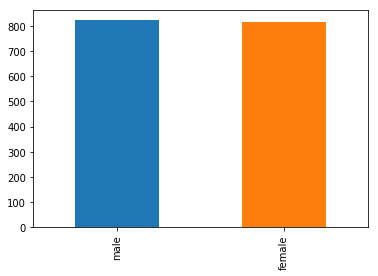

In [45]:
ax = demo_df.gender.value_counts().plot(kind='bar')
_ = ax.set_xticklabels(['male', 'female'])

In [46]:
df = pd.merge(df, demo_df, on='Respondent sequence number')

#### To calculate the target calorie intake, the Harris-Benedict equation revised by Mifflin and St Jeor formula was used. An activity level of moderate to accurate was assumed for everyone. Activity levels can change target calories by up to 20%.

In [47]:
def calc_target_calories(row):
    if row['gender'] == 1:
        bmr = (10 * row['target weight']) + (6.25 * row['height']) - (5 * row['age']) + 5
    if row['gender'] == 2:
        bmr = (10 * row['target weight']) + (6.25 * row['height']) - (5 * row['age']) - 161
    return bmr * 1.65

In [48]:
df['target_calories'] = df.apply(calc_target_calories, axis=1)

In [49]:
df['target_calories'].describe()

count    1120.000000
mean     1886.201257
std       463.571588
min       952.962161
25%      1533.325896
50%      1858.713945
75%      2216.560036
max      3043.698334
Name: target_calories, dtype: float64

In [50]:
df['target protein'] = df['target weight'] * 0.8

### Target carbs are calculated on the assumption that 60% of your calories should come from carbs, and the fact that carbs are 4 calories per gram.
https://www.fda.gov/food/resourcesforyou/consumers/ucm274593.htm

In [51]:
df['target carbs'] = df['target_calories'] * .6 / 4

### No value is calculated for target sugars as sugar is not seen as something that benefits one's diet. It is only seen as something that can harm one's diet if too much is consumed.

#### There are many different type of nutrients listed and it is hard to say which ones are the most important. I will create an additional feature that will be 'deviation from FDA daily recommended intakes.' This variable will be calculated on a percentage bases for each nutrition intake and then those percentage differences will be summed to achive a total deviation from FDA recommendations.

In [52]:
recommended_daily_values = {
    'Carbohydrate (gm)': 300,
    'Dietary fiber (gm)': 25,
    'Total fat (gm)': 65,
    'Total saturated fatty acids (gm)': 20,
    'Total monounsaturated fatty acids (gm)': 30,
    'Total polyunsaturated fatty acids (gm)': 15,
    'Cholesterol (mg)': 300,
    'Vitamin E as alpha-tocopherol (mg)': 15,
    'Retinol (mcg)': 800,
    'Vitamin A, RAE (mcg)': 900,
    'Alpha-carotene (mcg)': 21600,
    'Beta-carotene (mcg)': 4800,
    'Thiamin (Vitamin B1) (mg)': 1.2,
    'Riboflavin (Vitamin B2) (mg)': 1.3,
    'Niacin (mg)': 16,
    'Vitamin B6 (mg)': 1.7,
    'Total folate (mcg)': 400,
    'Folic acid (mcg)': 400,
    'Total choline (mg)': 550,
    'Vitamin B12 (mcg)': 2.4,
    'Vitamin C (mg)': 90,
    'Vitamin D (D2 + D3) (mcg)': 20,
    'Vitamin K (mcg)': 120,
    'Calcium (mg)': 1300,
    'Phosphorus (mg)': 1250,
    'Magnesium (mg)': 420,
    'Iron (mg)': 18,
    'Zinc (mg)': 11,
    'Copper (mg)': 0.9,
    'Sodium (mg)': 2400,
    'Potassium (mg)': 4700,
    'Selenium (mcg)': 55
}

In [53]:
df.isna().apply(pd.Series.value_counts, axis=0)

,Respondent sequence number,Number of foods reported,Energy (kcal),Protein (gm),Carbohydrate (gm),Total sugars (gm),Dietary fiber (gm),Total fat (gm),Total saturated fatty acids (gm),Total monounsaturated fatty acids (gm),...,weight,height,BMI,BMI category,target weight,age,gender,target_calories,target protein,target carbs
False,1120,1120,1120,1120,1120,1120,1120,1120,1120,1120,...,1120,1120,1120,1120,1120,1120,1120,1120,1120,1120


In [54]:
def calc_percent_deviation(target, actual):
    if target > actual:
        diff = target - actual
    else:
        diff = actual - target
    return (diff / target) ** 2

In [55]:
def calc_macro_dietary_deviation(row):
    total = 0
    target_actual_pairs = [
        (row['target protein'], row['Protein (gm)']),
        (row['target_calories'], row['Energy (kcal)'])
    ]
    for val in ['Carbohydrate (gm)', 'Dietary fiber (gm)', 'Total fat (gm)']:
        target_actual_pairs.append(
            (recommended_daily_values[val] * (row['target_calories'] / 2000), row[val])
        )
    for target, actual in target_actual_pairs:
        total += calc_percent_deviation(target, actual)
    return total

In [56]:
df['macro_deviation'] = df.apply(calc_macro_dietary_deviation, axis=1)

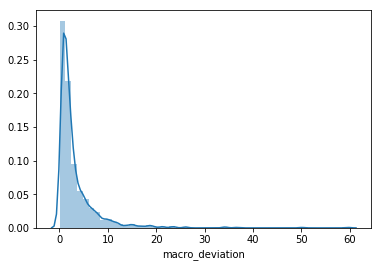

In [57]:
sns.distplot(df.macro_deviation)

(array([959., 115.,  26.,  13.,   2.,   2.,   1.,   0.,   1.,   1.]),
 array([5.20461952e-02, 6.01158571e+00, 1.19711252e+01, 1.79306647e+01,
        2.38902042e+01, 2.98497438e+01, 3.58092833e+01, 4.17688228e+01,
        4.77283623e+01, 5.36879018e+01, 5.96474413e+01]),
 <a list of 10 Patch objects>)

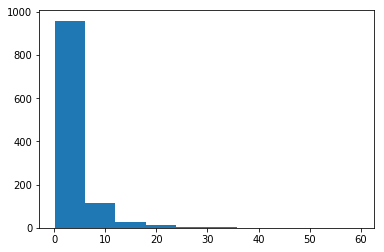

In [58]:
plt.hist(df.macro_deviation)

In [59]:
def calc_nutrient_deviation(row):
    total = 0
    nutrients = [
        'Total saturated fatty acids (gm)',
        'Total monounsaturated fatty acids (gm)',
        'Total polyunsaturated fatty acids (gm)',
        'Cholesterol (mg)',
        'Vitamin E as alpha-tocopherol (mg)',
        'Retinol (mcg)',
        'Vitamin A, RAE (mcg)',
        'Alpha-carotene (mcg)',
        'Beta-carotene (mcg)',
        'Thiamin (Vitamin B1) (mg)',
        'Riboflavin (Vitamin B2) (mg)',
        'Niacin (mg)',
        'Vitamin B6 (mg)',
        'Total folate (mcg)',
        'Folic acid (mcg)',
        'Total choline (mg)',
        'Vitamin B12 (mcg)',
        'Vitamin C (mg)',
        'Vitamin D (D2 + D3) (mcg)',
        'Vitamin K (mcg)',
        'Calcium (mg)',
        'Phosphorus (mg)',
        'Magnesium (mg)',
        'Iron (mg)',
        'Zinc (mg)',
        'Copper (mg)',
        'Sodium (mg)',
        'Potassium (mg)',
        'Selenium (mcg)'
    ]
    
    target_actual_pairs = [
        (recommended_daily_values[val] * (row['target_calories'] / 2000), row[val])
        for val in nutrients
    ]
    for target, actual in target_actual_pairs:
        total += calc_percent_deviation(target, actual)
    return total

In [60]:
df['nutrient_deviation'] = df.apply(calc_nutrient_deviation, axis=1)

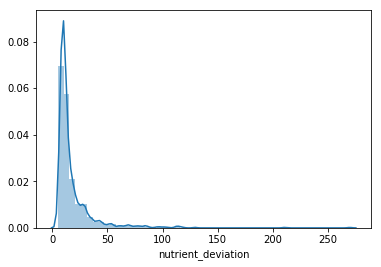

In [61]:
sns.distplot(df.nutrient_deviation)

(array([1.001e+03, 7.500e+01, 2.600e+01, 9.000e+00, 7.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([  4.939911  ,  31.40655987,  57.87320875,  84.33985763,
        110.8065065 , 137.27315538, 163.73980426, 190.20645313,
        216.67310201, 243.13975089, 269.60639976]),
 <a list of 10 Patch objects>)

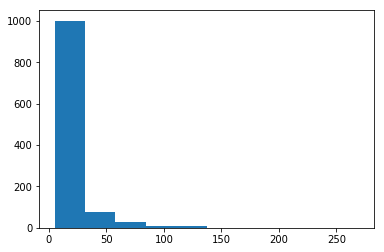

In [62]:
plt.hist(df.nutrient_deviation)

### Add calorie excess as a features

In [63]:
df['calorie_excess'] = df['Energy (kcal)'] - df['target_calories']

In [64]:
df = pd.get_dummies(df, columns=['BMI category', 'Tap water source', 'gender'])

In [65]:
df.shape

(1120, 74)

### Visualize some of the data

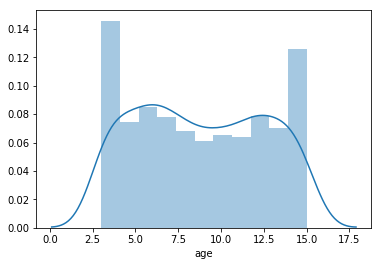

In [66]:
sns.distplot(df.age)

In [67]:
df.rename(columns={'height':'height (cm)'}, inplace=True)

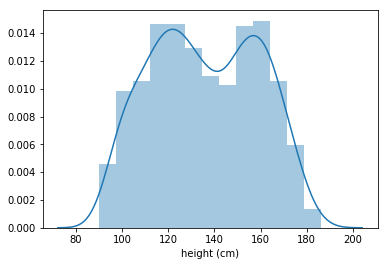

In [68]:
sns.distplot(df['height (cm)'])

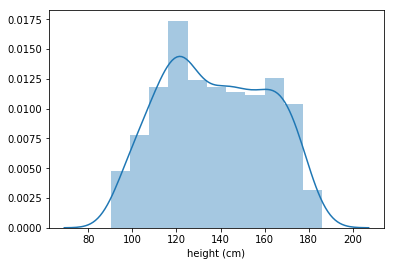

In [69]:
male_only = df[df['gender_1.0'] == 1]
sns.distplot(male_only['height (cm)'])

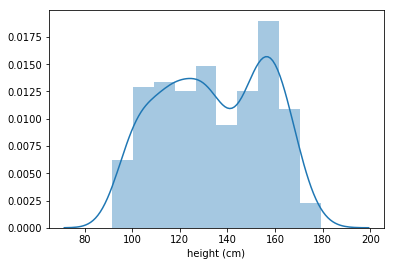

In [70]:
female_only = df[df['gender_2.0'] == 1]
sns.distplot(female_only['height (cm)'])

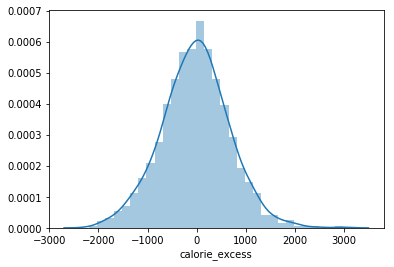

In [71]:
sns.distplot(df.calorie_excess)

### Attempt Feature Selection

In [72]:
df.var().sort_values()

Tap water source_91.0                       8.928571e-04
BMI category_1.0                            2.609154e-02
Tap water source_3.0                        3.197290e-02
Tap water source_99.0                       5.074684e-02
Tap water source_4.0                        1.238319e-01
Tap water source_2.0                        1.269876e-01
BMI category_3.0                            1.368178e-01
BMI category_4.0                            1.421678e-01
Copper (mg)                                 1.895939e-01
BMI category_2.0                            2.310537e-01
Tap water source_1.0                        2.361092e-01
gender_1.0                                  2.500670e-01
gender_2.0                                  2.500670e-01
Thiamin (Vitamin B1) (mg)                   5.376834e-01
Alcohol (gm)                                6.132403e-01
Riboflavin (Vitamin B2) (mg)                9.101880e-01
Vitamin B6 (mg)                             9.578097e-01
Added vitamin B12 (mcg)        

In [73]:
for col in ['Tap water source_3.0', 'Tap water source_99.0', 'Tap water source_4.0', 'Tap water source_2.0', 'Tap water source_1.0']:
    print(df[col].value_counts())

0    1083
1      37
Name: Tap water source_3.0, dtype: int64
0    1060
1      60
Name: Tap water source_99.0, dtype: int64
0    958
1    162
Name: Tap water source_4.0, dtype: int64
0    953
1    167
Name: Tap water source_2.0, dtype: int64
1    693
0    427
Name: Tap water source_1.0, dtype: int64


#### Initially from the variances it looked like the tap water source might be just about the same for everyone, but that actually doesn't seem to be the case. Through variance analysis, nothing pops out as an easy column to drop.

### Explore diet and BMI Category. BMI category 3 and 4 are overweight and obese respectively

In [74]:
df['overweight_or_obese'] = ((df['BMI category_3.0'] == 1) | (df['BMI category_4.0'] == 1))
targets = df.overweight_or_obese

### Scale the data before building any models

In [75]:
from sklearn.preprocessing import StandardScaler

In [76]:
scaler = StandardScaler()

In [77]:
scaler.fit(df)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [78]:
scaled_data = scaler.transform(df)
df = pd.DataFrame(scaled_data, df.index, df.columns)

In [79]:
data = df.drop(
    labels=[
        'BMI category_1.0', 'BMI category_2.0',
        'BMI category_3.0', 'BMI category_4.0',
        'overweight_or_obese', 'weight',
        'BMI', 'target weight', 
        'target_calories', 'target protein',
        'target carbs'
    ], axis=1)

In [80]:
from sklearn.model_selection import train_test_split

In [81]:
train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.2, random_state=4)

### Build a Linear Regression Model

In [82]:
import statsmodels.api as sm

/home/lance/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [83]:
model = sm.OLS(train_targets, train_data).fit()
predictions = model.predict(test_data) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     overweight_or_obese   R-squared:                    -257.083
Model:                             OLS   Adj. R-squared:               -275.937
Method:                  Least Squares   F-statistic:                    -13.64
Date:                 Sat, 27 Apr 2019   Prob (F-statistic):               1.00
Time:                         18:43:54   Log-Likelihood:                -713.76
No. Observations:                  896   AIC:                             1550.
Df Residuals:                      835   BIC:                             1842.
Df Model:                           61                                         
Covariance Type:             nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Respondent sequence number                  -0.0118      0.019     -0.621      0.535      -0.049       0.026
Number of foods reported                    -0.0277      0.024     -1.153      0.249      -0.075       0.020
Energy (kcal)                               -1.0171      1.360     -0.748      0.455      -3.687       1.653
Protein (gm)                                -0.3017      0.221     -1.366      0.172      -0.735       0.132
Carbohydrate (gm)                           -0.6372      0.628     -1.014      0.311      -1.870       0.596
Total sugars (gm)                            0.0408      0.060      0.674      0.501      -0.078       0.159
Dietary fiber (gm)                           0.0497      0.044      1.131      0.259      -0.037       0.136
Total fat (gm)                              -0.3241      0.643     -0.504      0.615      -1.587       0.939
Total saturated fatty acids (gm)            -0.0171      0.181     -0.095      0.925      -0.372       0.338
Total monounsaturated fatty acids (gm)      -0.0070      0.165     -0.042      0.966      -0.331       0.317
Total polyunsaturated fatty acids (gm)      -0.0225      0.133     -0.169      0.866      -0.284       0.239
Cholesterol (mg)                            -0.0640      0.072     -0.890      0.373      -0.205       0.077
Vitamin E as alpha-tocopherol (mg)          -0.0067      0.041     -0.166      0.868      -0.087       0.073
Added alpha-tocopherol (Vitamin E) (mg)     -0.0079      0.028     -0.279      0.780      -0.063       0.047
Retinol (mcg)                                7.6270      3.860      1.976      0.049       0.050      15.204
Vitamin A, RAE (mcg)                        -9.6273      4.859     -1.981      0.048     -19.164      -0.091
Alpha-carotene (mcg)                         0.7819      0.393      1.989      0.047       0.010       1.554
Beta-carotene (mcg)                          4.8884      2.474      1.976      0.048       0.033       9.744
Beta-cryptoxanthin (mcg)                     0.1225      0.078      1.579      0.115      -0.030       0.275
Lycopene (mcg)                              -0.0163      0.022     -0.739      0.460      -0.060       0.027
Lutein + zeaxanthin (mcg)                    0.1254      0.050      2.485      0.013       0.026       0.224
Thiamin (Vitamin B1) (mg)                   -0.0728      0.046     -1.569      0.117      -0.164       0.018
Riboflavin (Vitamin B2) (mg)                 0.0014      0.059      0.023      0.982      -0.115       0.118
Niacin (mg)                                 -0.0164      0.062     -0.266      0.790      -0.137       0.105
Vitamin B6 (mg)                              0.0226      0.061      0.371      0.711      -0.097       0.142
Total folate (mcg)  

In [84]:
from sklearn.linear_model import LinearRegression

In [85]:
lr = LinearRegression()

In [86]:
lr.fit(train_data, train_targets)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [87]:
y_pred = np.round(lr.predict(test_data))

In [88]:
lr.score(test_data, test_targets)

0.02635858928335877

In [89]:
from sklearn.metrics import accuracy_score

In [90]:
accuracy_score(test_targets, y_pred)

0.6964285714285714

In [91]:
from sklearn.metrics import confusion_matrix

In [92]:
confusion_matrix(test_targets, y_pred, labels=[False, True])

array([[128,  15],
       [ 52,  28]])

### Build a Gaussian Naive Bayes Model 

In [93]:
from sklearn.naive_bayes import GaussianNB

In [94]:
gnb = GaussianNB()

In [95]:
gnb.fit(train_data, train_targets)

GaussianNB(priors=None)

In [96]:
y_pred = gnb.predict(test_data)

In [97]:
accuracy_score(test_targets, y_pred)

0.6383928571428571

In [98]:
confusion_matrix(test_targets, y_pred, labels=[False, True])

array([[143,   1],
       [ 80,   0]])

### Build a KNN model

In [99]:
from sklearn.neighbors import KNeighborsClassifier

In [100]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(train_data, train_targets)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')

In [101]:
y_pred = knn.predict(test_data)

In [102]:
accuracy_score(test_targets, y_pred)

0.6517857142857143

In [103]:
confusion_matrix(test_targets, y_pred, labels=[False, True])

array([[138,   6],
       [ 72,   8]])

### Build a SVM model

In [104]:
from sklearn.svm import SVC

In [105]:
svm = SVC(kernel='linear')

In [106]:
svm.fit(train_data, train_targets)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [107]:
y_pred = svm.predict(test_data)

In [108]:
accuracy_score(test_targets, y_pred)

0.6919642857142857

In [109]:
confusion_matrix(test_targets, y_pred, labels=[False, True])

array([[137,   7],
       [ 62,  18]])

In [110]:
svm.coef_

array([[-3.07415620e-02, -1.23535789e-01, -8.44664215e-02,
        -3.76171833e-01, -3.28974089e-02, -6.06447516e-03,
         1.80427375e-01, -2.23939334e-01,  1.07474805e-01,
         1.34989898e-01,  1.76957334e-02, -1.59042021e-01,
         4.32112831e-02,  3.71200831e-03, -2.42749612e-02,
        -1.72214337e-01, -1.03286420e-02,  9.16242564e-02,
        -1.17559187e-01, -6.53984652e-02,  3.93177198e-01,
        -1.85389890e-01,  6.71719089e-02, -1.06759198e-01,
        -3.25131756e-02,  2.77975018e-02, -2.73400044e-02,
        -1.37758689e-03, -1.14314829e-02, -7.51425893e-02,
        -3.31661504e-02,  1.22378498e-01,  1.29059692e-02,
        -1.10055584e-01, -4.40874804e-01, -7.42070588e-02,
         4.67748404e-01, -2.13679631e-01,  3.05574146e-03,
         6.67177729e-02, -6.81813199e-02,  1.04219449e-01,
        -8.11556264e-02,  3.13586016e-01, -2.71530591e-02,
        -4.17673702e-02, -9.78412348e-02,  3.40858822e-01,
        -8.34491873e-02, -1.02806243e-01,  8.09321612e-0

### Build Grandient Booster

In [111]:
from sklearn.ensemble import GradientBoostingClassifier

In [112]:
gbc = GradientBoostingClassifier()

In [113]:
gbc.fit(train_data, train_targets)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [114]:
y_pred = gbc.predict(test_data)

In [115]:
accuracy_score(test_targets, y_pred)

0.6785714285714286

In [116]:
confusion_matrix(test_targets, y_pred, labels=[False, True])

array([[128,  16],
       [ 56,  24]])

### Build XGBooster

In [117]:
import xgboost

In [118]:
xgb_model = xgboost.XGBRegressor(objective="reg:linear", random_state=4)

In [119]:
xgb_model.fit(train_data, train_targets)

/home/lance/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=4, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [120]:
y_pred = np.round(xgb_model.predict(test_data))

In [121]:
accuracy_score(test_targets, y_pred)

0.6741071428571429

In [122]:
confusion_matrix(test_targets, y_pred, labels=[False, True])

array([[132,  12],
       [ 61,  19]])

### Build a neural network

In [123]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

/home/lance/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [124]:
train_data.shape

(896, 64)

In [125]:
nn = Sequential()
nn.add(Dense(70, input_dim=64, activation='relu'))
nn.add(Dense(50, activation='relu'))
nn.add(Dense(20, activation='relu'))
nn.add(Dense(5, activation='relu'))
nn.add(Dense(1, activation='sigmoid'))

In [126]:
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [127]:
nn.fit(train_data, train_targets, epochs=10, batch_size=10)

Epoch 1/10
896/896 [==============================] - 1s 669us/step - loss: 0.6518 - acc: 0.6641
Epoch 2/10
896/896 [==============================] - 0s 194us/step - loss: 0.6016 - acc: 0.6708
Epoch 3/10
896/896 [==============================] - 0s 187us/step - loss: 0.5767 - acc: 0.6708
Epoch 4/10
896/896 [==============================] - 0s 212us/step - loss: 0.5503 - acc: 0.6730
Epoch 5/10
896/896 [==============================] - 0s 206us/step - loss: 0.5209 - acc: 0.7042
Epoch 6/10
896/896 [==============================] - 0s 186us/step - loss: 0.5003 - acc: 0.7422
Epoch 7/10
896/896 [==============================] - 0s 173us/step - loss: 0.4594 - acc: 0.7779
Epoch 8/10
896/896 [==============================] - 0s 186us/step - loss: 0.4245 - acc: 0.8025
Epoch 9/10
896/896 [==============================] - 0s 172us/step - loss: 0.3886 - acc: 0.8404
Epoch 10/10
896/896 [==============================] - 0s 188us/step - loss: 0.3427 - acc: 0.8616


In [128]:
y_pred = np.round(nn.predict(test_data))

In [129]:
accuracy_score(test_targets, y_pred)

0.6517857142857143

In [130]:
confusion_matrix(test_targets, y_pred, labels=[False, True])

array([[120,  24],
       [ 54,  26]])

### Do recursive feature elimination with the SVM model

In [131]:
from sklearn.feature_selection import RFE

In [132]:
eliminator = RFE(svm, n_features_to_select=10)

In [133]:
eliminator.fit(train_data, train_targets)

RFE(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
  n_features_to_select=10, step=1, verbose=0)

In [134]:
eliminator.support_

array([False, False, False,  True,  True, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False,  True,  True, False,
       False,  True, False, False, False, False, False, False, False,
       False])

In [135]:
kept_features = []
for col, keeper in zip(train_data.columns, eliminator.support_):
    if keeper:
        kept_features.append(col)
kept_features

['Protein (gm)',
 'Carbohydrate (gm)',
 'Cholesterol (mg)',
 'Lutein + zeaxanthin (mcg)',
 'Thiamin (Vitamin B1) (mg)',
 'Vitamin K (mcg)',
 'Selenium (mcg)',
 'height (cm)',
 'age',
 'calorie_excess']

In [136]:
lost_features = []
for col, keeper in zip(train_data.columns, eliminator.support_):
    if not keeper:
        lost_features.append(col)
lost_features

['Respondent sequence number',
 'Number of foods reported',
 'Energy (kcal)',
 'Total sugars (gm)',
 'Dietary fiber (gm)',
 'Total fat (gm)',
 'Total saturated fatty acids (gm)',
 'Total monounsaturated fatty acids (gm)',
 'Total polyunsaturated fatty acids (gm)',
 'Vitamin E as alpha-tocopherol (mg)',
 'Added alpha-tocopherol (Vitamin E) (mg)',
 'Retinol (mcg)',
 'Vitamin A, RAE (mcg)',
 'Alpha-carotene (mcg)',
 'Beta-carotene (mcg)',
 'Beta-cryptoxanthin (mcg)',
 'Lycopene (mcg)',
 'Riboflavin (Vitamin B2) (mg)',
 'Niacin (mg)',
 'Vitamin B6 (mg)',
 'Total folate (mcg)',
 'Folic acid (mcg)',
 'Food folate (mcg)',
 'Folate, DFE (mcg)',
 'Total choline (mg)',
 'Vitamin B12 (mcg)',
 'Added vitamin B12 (mcg)',
 'Vitamin C (mg)',
 'Vitamin D (D2 + D3) (mcg)',
 'Calcium (mg)',
 'Phosphorus (mg)',
 'Magnesium (mg)',
 'Iron (mg)',
 'Zinc (mg)',
 'Copper (mg)',
 'Sodium (mg)',
 'Potassium (mg)',
 'Caffeine (mg)',
 'Theobromine (mg)',
 'Alcohol (gm)',
 'Moisture (gm)',
 'Total plain water dran

### SVM with the 'most important' features

In [137]:
new_train_data = train_data[kept_features]
new_test_data = test_data[kept_features]

In [138]:
svm.fit(new_train_data, train_targets)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [139]:
y_pred = svm.predict(new_test_data)

In [140]:
accuracy_score(test_targets, y_pred)

0.6428571428571429

In [141]:
confusion_matrix(test_targets, y_pred, labels=[False, True])

array([[144,   0],
       [ 80,   0]])

### SVM with the 'least important' features

In [142]:
new2_train_data = train_data[lost_features]
new2_test_data = test_data[lost_features]

In [143]:
svm.fit(new2_train_data, train_targets)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [144]:
y_pred = svm.predict(new2_test_data)

In [145]:
accuracy_score(test_targets, y_pred)

0.6428571428571429

In [146]:
confusion_matrix(test_targets, y_pred, labels=[False, True])

array([[144,   0],
       [ 80,   0]])

### NN With the most important features

In [147]:
nn = Sequential()
nn.add(Dense(8, input_dim=10, activation='relu'))
nn.add(Dense(5, activation='relu'))
nn.add(Dense(2, activation='relu'))
nn.add(Dense(1, activation='sigmoid'))

In [148]:
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [149]:
nn.fit(new_train_data, train_targets, epochs=30, batch_size=10)

Epoch 1/30
896/896 [==============================] - 1s 625us/step - loss: 0.6691 - acc: 0.6708
Epoch 2/30
896/896 [==============================] - 0s 159us/step - loss: 0.6393 - acc: 0.6708
Epoch 3/30
896/896 [==============================] - 0s 157us/step - loss: 0.6257 - acc: 0.6708
Epoch 4/30
896/896 [==============================] - 0s 161us/step - loss: 0.6202 - acc: 0.6708
Epoch 5/30
896/896 [==============================] - 0s 141us/step - loss: 0.6171 - acc: 0.6708
Epoch 6/30
896/896 [==============================] - 0s 167us/step - loss: 0.6146 - acc: 0.6708
Epoch 7/30
896/896 [==============================] - 0s 164us/step - loss: 0.6126 - acc: 0.6708
Epoch 8/30
896/896 [==============================] - 0s 166us/step - loss: 0.6105 - acc: 0.6708
Epoch 9/30
896/896 [==============================] - 0s 164us/step - loss: 0.6091 - acc: 0.6708
Epoch 10/30
896/896 [==============================] - 0s 162us/step - loss: 0.6076 - acc: 0.6708
Epoch 11/30
896/896 [========

In [150]:
y_pred = np.round(nn.predict(new_test_data))

In [151]:
accuracy_score(test_targets, y_pred)

0.6607142857142857

In [152]:
confusion_matrix(test_targets, y_pred, labels=[False, True])

array([[133,  11],
       [ 65,  15]])

### Recursive features elimination with a linear regression

In [153]:
eliminator = RFE(lr, n_features_to_select=10)

In [154]:
eliminator.fit(train_data, train_targets)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
  n_features_to_select=10, step=1, verbose=0)

In [155]:
eliminator.support_

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
       False,  True, False, False, False, False, False, False,  True,
       False])

In [156]:
kept_features = []
for col, keeper in zip(train_data.columns, eliminator.support_):
    if keeper:
        kept_features.append(col)
kept_features

['Energy (kcal)',
 'Vitamin A, RAE (mcg)',
 'Total folate (mcg)',
 'Folic acid (mcg)',
 'Food folate (mcg)',
 'Folate, DFE (mcg)',
 'height (cm)',
 'age',
 'calorie_excess',
 'gender_1.0']

In [157]:
lost_features = []
for col, keeper in zip(train_data.columns, eliminator.support_):
    if not keeper:
        lost_features.append(col)
lost_features

['Respondent sequence number',
 'Number of foods reported',
 'Protein (gm)',
 'Carbohydrate (gm)',
 'Total sugars (gm)',
 'Dietary fiber (gm)',
 'Total fat (gm)',
 'Total saturated fatty acids (gm)',
 'Total monounsaturated fatty acids (gm)',
 'Total polyunsaturated fatty acids (gm)',
 'Cholesterol (mg)',
 'Vitamin E as alpha-tocopherol (mg)',
 'Added alpha-tocopherol (Vitamin E) (mg)',
 'Retinol (mcg)',
 'Alpha-carotene (mcg)',
 'Beta-carotene (mcg)',
 'Beta-cryptoxanthin (mcg)',
 'Lycopene (mcg)',
 'Lutein + zeaxanthin (mcg)',
 'Thiamin (Vitamin B1) (mg)',
 'Riboflavin (Vitamin B2) (mg)',
 'Niacin (mg)',
 'Vitamin B6 (mg)',
 'Total choline (mg)',
 'Vitamin B12 (mcg)',
 'Added vitamin B12 (mcg)',
 'Vitamin C (mg)',
 'Vitamin D (D2 + D3) (mcg)',
 'Vitamin K (mcg)',
 'Calcium (mg)',
 'Phosphorus (mg)',
 'Magnesium (mg)',
 'Iron (mg)',
 'Zinc (mg)',
 'Copper (mg)',
 'Sodium (mg)',
 'Potassium (mg)',
 'Selenium (mcg)',
 'Caffeine (mg)',
 'Theobromine (mg)',
 'Alcohol (gm)',
 'Moisture (gm

### Linear Regression with the 'most important' features

In [158]:
new_train_data = train_data[kept_features]
new_test_data = test_data[kept_features]

In [159]:
lr.fit(new_train_data, train_targets)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [160]:
y_pred = np.round(lr.predict(new_test_data))

In [161]:
accuracy_score(test_targets, y_pred)

0.7276785714285714

In [162]:
confusion_matrix(test_targets, y_pred, labels=[False, True])

array([[139,   5],
       [ 56,  24]])

### Linear Regression with the 'least important' features

In [163]:
new2_train_data = train_data[lost_features]
new2_test_data = test_data[lost_features]

In [164]:
lr.fit(new2_train_data, train_targets)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [165]:
y_pred = np.round(lr.predict(new2_test_data))

In [166]:
accuracy_score(test_targets, y_pred)

0.6339285714285714

In [167]:
confusion_matrix(test_targets, y_pred, labels=[False, True])

array([[133,  11],
       [ 71,   9]])

### Linear regression with the features I think matter

In [168]:
data.columns

Index(['Respondent sequence number', 'Number of foods reported',
       'Energy (kcal)', 'Protein (gm)', 'Carbohydrate (gm)',
       'Total sugars (gm)', 'Dietary fiber (gm)', 'Total fat (gm)',
       'Total saturated fatty acids (gm)',
       'Total monounsaturated fatty acids (gm)',
       'Total polyunsaturated fatty acids (gm)', 'Cholesterol (mg)',
       'Vitamin E as alpha-tocopherol (mg)',
       'Added alpha-tocopherol (Vitamin E) (mg)', 'Retinol (mcg)',
       'Vitamin A, RAE (mcg)', 'Alpha-carotene (mcg)', 'Beta-carotene (mcg)',
       'Beta-cryptoxanthin (mcg)', 'Lycopene (mcg)',
       'Lutein + zeaxanthin (mcg)', 'Thiamin (Vitamin B1) (mg)',
       'Riboflavin (Vitamin B2) (mg)', 'Niacin (mg)', 'Vitamin B6 (mg)',
       'Total folate (mcg)', 'Folic acid (mcg)', 'Food folate (mcg)',
       'Folate, DFE (mcg)', 'Total choline (mg)', 'Vitamin B12 (mcg)',
       'Added vitamin B12 (mcg)', 'Vitamin C (mg)',
       'Vitamin D (D2 + D3) (mcg)', 'Vitamin K (mcg)', 'Calcium (mg)',


In [169]:
kept_features = [
    'Energy (kcal)', 'Protein (gm)', 'Carbohydrate (gm)',
    'Total sugars (gm)', 'Dietary fiber (gm)', 'Total fat (gm)',
    'height (cm)', 'age', 'gender_1.0', 'gender_2.0', 'macro_deviation',
    'nutrient_deviation', 'calorie_excess'
]
new_train_data = train_data[kept_features]
new_test_data = test_data[kept_features]

In [170]:
lr.fit(new_train_data, train_targets)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [171]:
y_pred = np.round(lr.predict(new_test_data))

In [172]:
accuracy_score(test_targets, y_pred)

0.7098214285714286

In [173]:
confusion_matrix(test_targets, y_pred, labels=[False, True])

array([[138,   6],
       [ 59,  21]])

In [174]:
model = sm.OLS(train_targets, new_train_data).fit()
predictions = model.predict(new_test_data) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     overweight_or_obese   R-squared:                    -274.264
Model:                             OLS   Adj. R-squared:               -278.000
Method:                  Least Squares   F-statistic:                    -73.40
Date:                 Sat, 27 Apr 2019   Prob (F-statistic):               1.00
Time:                         18:44:16   Log-Likelihood:                -742.63
No. Observations:                  896   AIC:                             1509.
Df Residuals:                      884   BIC:                             1567.
Df Model:                           12                                         
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Energy (kcal)         -0.3780      1.209     -0.313      0.755      -2.750       1.994
Protein (gm)          -0.2377      0.175     -1.360      0.174      -0.581       0.105
Carbohydrate (gm)     -0.6478      0.515     -1.257      0.209      -1.659       0.364
Total sugars (gm)     -0.0060      0.043     -0.140      0.889      -0.090       0.078
Dietary fiber (gm)     0.0320      0.032      1.009      0.313      -0.030       0.094
Total fat (gm)        -0.4801      0.381     -1.261      0.208      -1.227       0.267
height (cm)            1.5073      0.506      2.979      0.003       0.514       2.500
age                   -0.4864      0.072     -6.745      0.000      -0.628      -0.345
gender_1.0             0.1508      0.075      2.021      0.044       0.004       0.297
gender_2.0            -0.1508      0.075     -2.021      0.044      -0.297      -0.004
macro_deviation        0.0542      0.034      1.600      0.110      -0.012       0.121
nutrient_deviation    -0.0369      0.030     -1.245      0.213      -0.095       0.021
calorie_excess         1.5513      0.741      2.094      0.037       0.097       3.005
==============================================================================
Omnibus:                      610.846   Durbin-Watson:                   1.371
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.289
Skew:                           0.624   Prob(JB):                     1.12e-24
Kurtosis:                       1.819   Cond. No.                     7.62e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.26e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Analysis Conclusions

### Linear regression with feature elimination seems to be the most successful so far but it still does a poor job of fitting the data. 

The only variables with any meaning are height, age, and calorie excess. It seems that as height and calorie_excess increase, so does the likelihood of being overweight. As age increases, the likelihood of being overweight decreases. However, these three conclusions should be accepted with some skepticism. Although the P values were low for these specific variables, the R^2 and adjusted R^2 value suggested this model is very poorly fitted to the data as a whole.

More interesting however is what the data doesn't show to be important. It is very interesting that things like calories, carbs, fat, and macro_deviation, have seemingly no effect.

With all the data and analysis, I am lead to believe there are other factors not captured by the data, that are the true causal variables of being overweight or obese. Such factors could include things like exercise and play, genetic factors, and stress / happiness.